<a href="https://colab.research.google.com/github/ClaudeCoulombe/VIARENA/blob/master/Labos/Lab-Ecorces_Arbres/IdEcorces-ResConv-Transfert-Colab" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Rappel - Fonctionnement d'un carnet web iPython

* Pour exécuter le code contenu dans une cellule d'un carnet iPython, cliquez dans la cellule et faites (⇧↵, shift-enter) 
* Le code d'un carnet iPython s'exécute séquentiellement de haut en bas de la page. Souvent, l'importation d'une bibliothèque Python ou l'initialisation d'une variable est préalable à l'exécution d'une cellule située plus bas. Il est donc recommandé d'exécuter les cellules en séquence. Enfin, méfiez-vous des retours en arrière qui peuvent réinitialiser certaines variables.

SVP, déployez toutes les cellules en sélectionnant l'item « Développer les rubriques » de l'onglet « Affichage ».

# Identification d'arbres à partir de leur écorce

## Réseau convolutif avec apprentissage par transfert et peaufinage

### Inspiration et droits d'auteur

Ce laboratoire s'inspire de plusieurs oeuvres en logiciels libres qui ont été transformées dont:

<a href="https://www.tensorflow.org/tutorials/images/transfer_learning" target='_blank'>Transfer learning and fine-tuning</a> - site Google / Tutoriels TensorFlow

##### Copyright (c) 2017, François Chollet  
##### Copyright (c) 2019-2022, The TensorFlow Authors.
##### Copyright (c) 2022, Claude Coulombe

Le contenu de cette page est sous licence <a href="https://creativecommons.org/licenses/by/4.0/deed.fr" target='_blank'>Creative Commons Attribution 4.0 (CC BY 4.0)</a>,<br/>et les exemples de code sont sous <a href="https://www.apache.org/licenses/LICENSE-2.0" target='_blank'>licence Apache 2.0</a>.

#### Données

Les données sur les écorces d'arbres proviennent de <a href="https://data.mendeley.com/research-data/?search=barknet">BarkNet</a>, une banque en données ouvertes sous licence MIT de 23 000 photos d'écorces d'arbres en haute résolution prises avec des téléphones intelligents par une équipe d'étudiants et de chercheurs du <a href="https://www.sbf.ulaval.ca/" target='_blank'>Département des sciences du bois et de la forêt de l'Université Laval</a> à Québec.</p>

# Apprentissage par transfert & peaufinage

## Fixer le hasard pour la reproductibilité

La mise au point de réseaux de neurones implique certains processus aléatoires. Afin de pouvoir reproduire et comparer vos résultats d'expérience, vous fixez temporairement l'état aléatoire grâce à un germe aléatoire unique.

Pendant la mise au point, vous fixez temporairement l'état aléatoire pour la reproductibilité mais vous répétez l'expérience avec différents germes ou états aléatoires et prenez la moyenne des résultats.
<br/>
**Note** : Pour un système en production, vous ravivez simplement l'état  purement aléatoire avec l'instruction `GERME_ALEATOIRE = None`

In [ ]:
import os

# Définir un germe aléatoire
GERME_ALEATOIRE = 42

# Définir un état aléatoire pour Python
os.environ['PYTHONHASHSEED'] = str(GERME_ALEATOIRE)

# Définir un état aléatoire pour Python random
import random
random.seed(GERME_ALEATOIRE)

# Définir un état aléatoire pour NumPy
import numpy as np
np.random.seed(GERME_ALEATOIRE)

# Définir un état aléatoire pour TensorFlow
import tensorflow as tf
tf.random.set_seed(GERME_ALEATOIRE)

# Note: Retrait du comportement déterministe
# à cause de keras.layers.RandomContrast(...)
# dont il n'existe pas de version déterministe
# os.environ['TF_DETERMINISTIC_OPS'] = '1'
# os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

print("Germe aléatoire fixé")

## Acquisition des données

Les <a href="https://www.kaggle.com/claudecoulombe/barknet" target='_blank'>données de BarkNet</a>  sont téléchargeables à partir du site de Kaggle.


In [ ]:
dict_arbres = {
    'BOJ' : "Betula alleghaniensis - Bouleau jaune - Yellow birch",
    'BOP' : "Betula papyrifera - Bouleau à papier - White birch",
    'CHR' : "Quercus rubra - Chêne rouge - Northern red oak",
    'EPB' : "Picea glauca - Épinette blanche - White spruce",
    'EPN' : " Picea mariana - Épinette noire - Black spruce",
    'EPO' : "Picea abies - Épinette de Norvège - Norway spruce",
    'EPR' : "Picea rubens - Épinette rouge - Red spruce",
    'ERB' : "Acer platanoides - Érable de Norvège - Norway maple",
    'ERR' : "Acer rubrum - Érable rouge - Red maple",
    'ERS' : "Acer saccharum - Érable à sucre - Sugar maple",
    'FRA' : "Fraxinus americana - Frêne d'Amérique - White ash",
    'HEG' : "Fagus grandifolia - Hêtre à grandes feuilles - American beech",
    'MEL' : "Larix laricina - Mélèze - Tamarack",
    'ORA' : "Ulmus americana - Orme d'Amérique - American elm",
    'OSV' : "Ostrya virginiana - Ostryer de Virginie - American hophornbeam",
    'PEG' : "Populus grandidentata - Peuplier à grandes dents - Big-tooth aspen",
    'PET' : "Populus tremuloides - Peuplier faux tremble - Quaking aspen",
    'PIB' : "Pinus strobus - Pin blanc - Eastern white pine",
    'PID' : "Pinus rigida - Pin rigide - Pitch pine",
    'PIR' : "Pinus resinosa - Pin rouge - Red pine",
    'PRU' : "Tsuga canadensis - Pruche du Canada - Eastern Hemlock",
    'SAB' : "Abies balsamea - Sapin Baumier - Balsam fir",
    'THO' : "Thuja occidentalis - Thuya occidental - Northern white cedar",
}
print("Dictionnaire mémorisé")

### Création des répertoires de données

Nous allons créer un répertoire de base `donnees`, un répertoire `lab_ecorces` où les données seront réparties en données d'entraînement, de validation et de test pour chaque classe cible.

Enfin, un répertoire `modeles` pour mémoriser les modèles une fois entraînés.

In [ ]:
try:
    os.mkdir("/content/donnees/")
except OSError:
    pass
try:
    os.mkdir("/content/lab_ecorces/")
except OSError:
    pass
try:
    os.mkdir("/content/modeles/")
except OSError:
    pass

### Utilisation de l'IPA (<i>API</i>) de Kaggle pour l'importation directe du jeu de données BarkNet

1. Commencez par installer la bibliothèque Python `kaggle`

In [ ]:
!pip3 install kaggle

2. Si ce n'est déjà fait, devenez membre de Kaggle avec votre adresse de courriel GMail:<br/>

<img src="https://cours.edulib.org/asset-v1:Cegep-Matane+VAERN.1FR+P2021+type@asset+block@Kaggle_API-1.png"/>


3. Maintenant, vous devez télécharger votre clé privée pour utiliser l'IPA de Kaggle.

4. Cliquez sur l'onglet « account » de votre profil Kaggle

<img src="https://cours.edulib.org/asset-v1:Cegep-Matane+VAERN.1FR+P2021+type@asset+block@Kaggle_API-2.png"/>

5. Sur la page « Account » cliquez sur le bouton « Create New API Token ».
    
<img style="margin-left:40px;" src="https://cours.edulib.org/asset-v1:Cegep-Matane+VAERN.1FR+P2021+type@asset+block@Kaggle_API-3.png"/>

6. Téléchargez votre clé privée « kaggle.json » pour l'IPA Kaggle dans un endroit temporaire sur votre poste de travail.

<img style="margin-left:40px;" src="https://cours.edulib.org/asset-v1:Cegep-Matane+VAERN.1FR+P2021+type@asset+block@Kaggle_API-5.png"/>

7. Maintenant, transférez (téléversez) votre clé privée « kaggle.json » dans votre environnement Colab.

La fenêtre de l'outil de fichiers de votre ordinateur s'ouvre alors. Allez chercher votre clé privée « kaggle.json » que vous avez sauvegardé sur votre  ordinateur.

<img style="margin-left:40px;" src="https://cours.edulib.org/asset-v1:Cegep-Matane+VAERN.1FR+P2021+type@asset+block@Colab_Importer_Fichier.png"/>



8. Créer à la racine un répertoire .kaggle et déplacez votre clé privée « kaggle.json » dans ce répertoire.

In [ ]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle -all

9. Maintenant téléchargez le jeu de données réduit « barknet-mini » de 1.6 Go ou le jeu de données « barknet » complet de 32 Go avec la commande suivante:

In [46]:
# Attention! Jeu réduit de données 1.5 Go - plus rapide à télécharger et à traiter
!kaggle datasets download claudecoulombe/barknet-mini --unzip -p /content/donnees/
repertoire_entree = "/content/donnees/BarkNet-mini"

404 - Not Found


In [42]:
# Attention! Jeu complet de données 32 Go - plus long à télécharger et à traiter
!kaggle datasets download claudecoulombe/barknet --unzip -p /content/donnees/
repertoire_entree = "/content/donnees/BarkNet"

100% 30.1G/30.1G [03:36<00:00, 123MB/s]
100% 30.1G/30.1G [03:36<00:00, 150MB/s]


### Répartition des données

In [43]:
# Installation des bibliothèques Python `split-folders` et `tqdm`
!pip3 install split-folders tqdm

In [45]:
# Répartition des données d'entraînement, de validation et de tests
import splitfolders
import pathlib

#### répertoire des données une fois réparties
repertoire_donnees_reparties = "/content/lab_ecorces"
# => train, val, test

nombre_images = len(list(pathlib.Path(repertoire_entree).glob('*/*.jpg')))
print("Nombre total d'images:",nombre_images)

splitfolders.ratio(repertoire_entree, 
                   output=repertoire_donnees_reparties, 
                   seed=42, 
                   ratio = (0.80, 0.15, 0.05))

print("\nRépartition des données terminée!")


Nombre total d'images: 23528


Copying files: 23528 files [04:08, 94.52 files/s] 


Répartition des données terminée!


### Visualisation d'un échantillon des données

__________________________________________________________________________________________
BOJ  Bouleau jaune 
/content/lab_ecorces/train/BOJ/461_BOJ_53_GalaxyS7_20170607_145206_14.jpg
/content/lab_ecorces/train/BOJ/20_BOJ_120_Nexus 5_20170607_155339_23.jpg
/content/lab_ecorces/train/BOJ/639_BOJ_80_GalaxyS5_20170615_103720_22.jpg
/content/lab_ecorces/train/BOJ/649_BOJ_84_GalaxyS5_20170615_134155_15.jpg


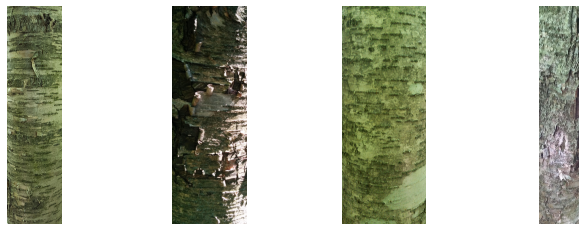

__________________________________________________________________________________________
BOP  Bouleau à papier 
/content/lab_ecorces/train/BOP/470_BOP_63_GalaxyS7_20170607_153015_29.jpg
/content/lab_ecorces/train/BOP/465_BOP_55_GalaxyS5_20170607_140839_7.jpg
/content/lab_ecorces/train/BOP/473_BOP_30_GalaxyS5_20170607_154446_33.jpg
/content/lab_ecorces/train/BOP/666_BOP_68_GalaxyS5_20170712_111247_24.jpg


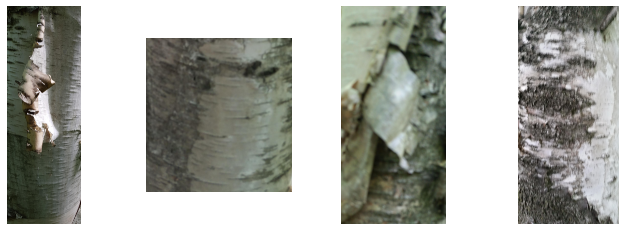

__________________________________________________________________________________________
CHR  Chêne rouge 
/content/lab_ecorces/train/CHR/484_CHR_201_GalaxyS7_20170916_150524_3.jpg
/content/lab_ecorces/train/CHR/675_CHR_96_GalaxyS5_20170615_104301_21.jpg
/content/lab_ecorces/train/CHR/485_CHR_175_GalaxyS7_20170916_150927_9.jpg
/content/lab_ecorces/train/CHR/681_CHR_90_GalaxyS5_20170713_110456_4.jpg


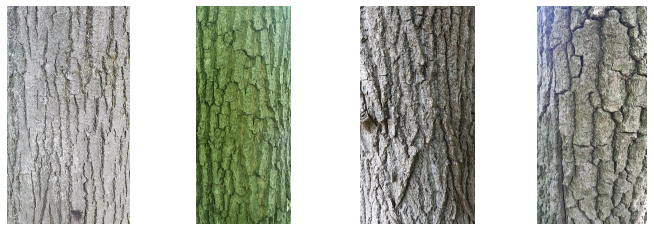

__________________________________________________________________________________________
EPB  Épinette blanche 
/content/lab_ecorces/train/EPB/685_EPB_62_GalaxyS5_20170712_122435_7.jpg
/content/lab_ecorces/train/EPB/92_EPB_72_Nexus 5_20170817_111310_12.jpg
/content/lab_ecorces/train/EPB/688_EPB_68_GalaxyS5_20170712_122720_6.jpg
/content/lab_ecorces/train/EPB/685_EPB_62_GalaxyS5_20170712_122435_10.jpg


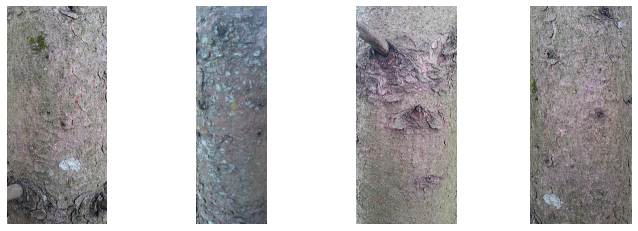

__________________________________________________________________________________________
EPN  Épinette noire 
/content/lab_ecorces/train/EPN/695_EPN_82_GalaxyS5_20170622_100334_4.jpg
/content/lab_ecorces/train/EPN/699_EPN_98_GalaxyS5_20170622_100838_8.jpg
/content/lab_ecorces/train/EPN/713_EPN_70_GalaxyS5_20170622_104039_7.jpg
/content/lab_ecorces/train/EPN/728_EPN_89_GalaxyS5_20170622_112256_18.jpg


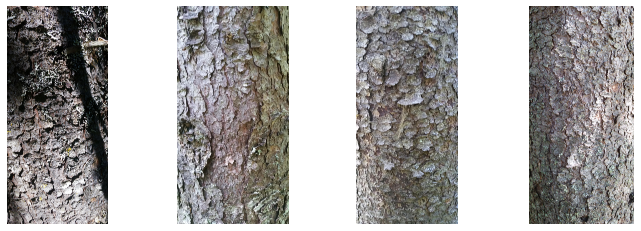

__________________________________________________________________________________________
EPO  Épinette de Norvège 
/content/lab_ecorces/train/EPO/152_EPO_69_Nexus 5_20170921_154959_4.jpg
/content/lab_ecorces/train/EPO/123_EPO_155_Nexus 5_20170921_151315_9.jpg
/content/lab_ecorces/train/EPO/124_EPO_105_Nexus 5_20170921_151420_21.jpg
/content/lab_ecorces/train/EPO/156_EPO_111_Nexus 5_20170922_095827_8.jpg


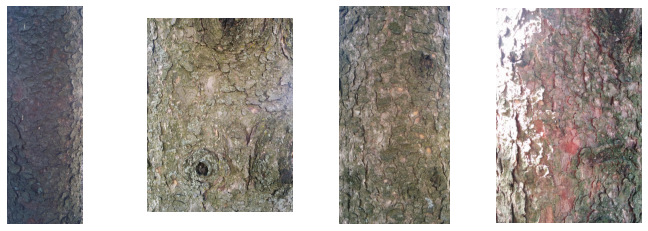

__________________________________________________________________________________________
EPR  Épinette rouge 
/content/lab_ecorces/train/EPR/176_EPR_50_Nexus 5_20170608_102218_6.jpg
/content/lab_ecorces/train/EPR/535_EPR_60_GalaxyS5_20170607_143651_24.jpg
/content/lab_ecorces/train/EPR/180_EPR_97_Nexus 5_20170608_102619_2.jpg
/content/lab_ecorces/train/EPR/183_EPR_87_Nexus 5_20170608_102904_7.jpg


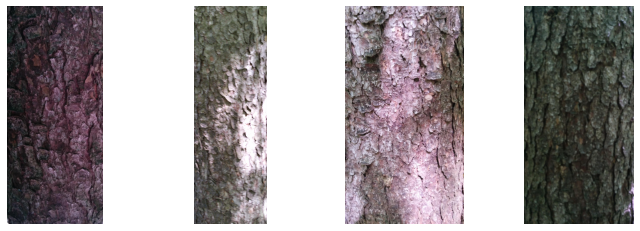

__________________________________________________________________________________________
ERB  Érable de Norvège 
/content/lab_ecorces/train/ERB/541_ERB_70_GalaxyS5_20170607_151651_17.jpg
/content/lab_ecorces/train/ERB/541_ERB_70_GalaxyS7_20170607_151858_7.jpg
/content/lab_ecorces/train/ERB/541_ERB_70_GalaxyS5_20170607_151651_12.jpg
/content/lab_ecorces/train/ERB/541_ERB_70_GalaxyS5_20170607_151651_11.jpg


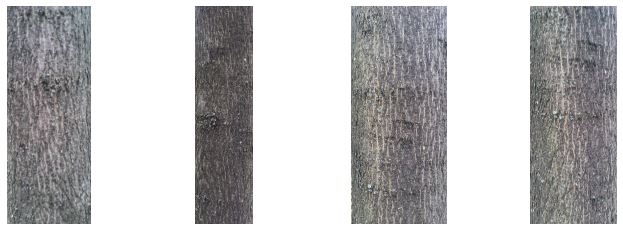

__________________________________________________________________________________________
ERR  Érable rouge 
/content/lab_ecorces/train/ERR/547_ERR_124_GalaxyS7_20170922_123531_18.jpg
/content/lab_ecorces/train/ERR/565_ERR_53_GalaxyS7_20170922_132021_19.jpg
/content/lab_ecorces/train/ERR/765_ERR_83_GalaxyS5_20170615_112933_29.jpg
/content/lab_ecorces/train/ERR/568_ERR_117_GalaxyS5_20170607_141032_34.jpg


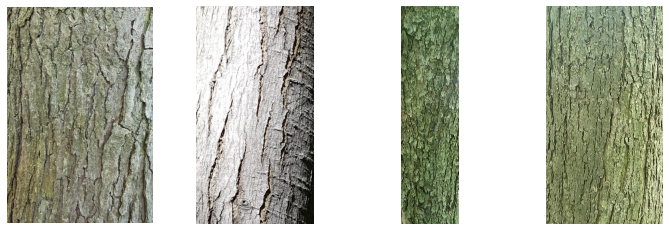

__________________________________________________________________________________________
ERS  Érable à sucre 
/content/lab_ecorces/train/ERS/596_ERS_214_GalaxyS5_20170607_135644_28.jpg
/content/lab_ecorces/train/ERS/774_ERS_85_GalaxyS5_20170615_115418_12.jpg
/content/lab_ecorces/train/ERS/239_ERS_130_Nexus 5_20170804_102607_11.jpg
/content/lab_ecorces/train/ERS/224_ERS_94_Nexus 5_20170804_093453_7.jpg


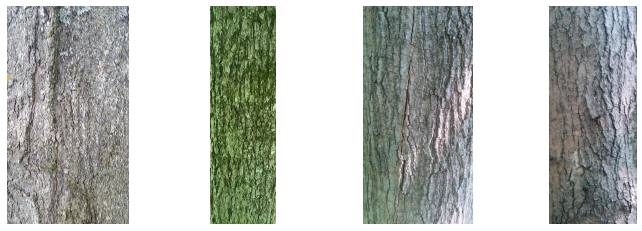

__________________________________________________________________________________________
FRA  Frêne d'Amérique 
/content/lab_ecorces/train/FRA/603_FRA_80_GalaxyS5_20170607_145903_29.jpg
/content/lab_ecorces/train/FRA/610_FRA_53_GalaxyS5_20170607_155105_6.jpg
/content/lab_ecorces/train/FRA/601_FRA_142_GalaxyS7_20170607_143908_3.jpg
/content/lab_ecorces/train/FRA/608_FRA_49_GalaxyS7_20170607_152327_31.jpg


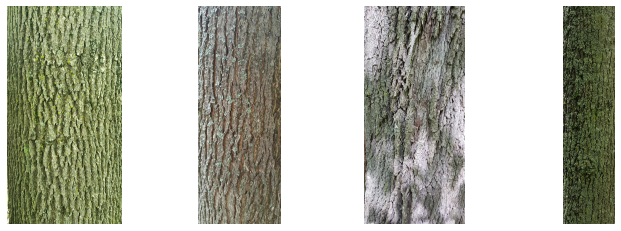

__________________________________________________________________________________________
HEG  Hêtre à grandes feuilles 
/content/lab_ecorces/train/HEG/623_HEG_86_GalaxyS7_20170916_180146_18.jpg
/content/lab_ecorces/train/HEG/798_HEG_88_GalaxyS5_20170713_101954_16.jpg
/content/lab_ecorces/train/HEG/273_HEG_105_GalaxyS7_20170607_155920_17.jpg
/content/lab_ecorces/train/HEG/801_HEG_71_GalaxyS5_20170713_111457_15.jpg


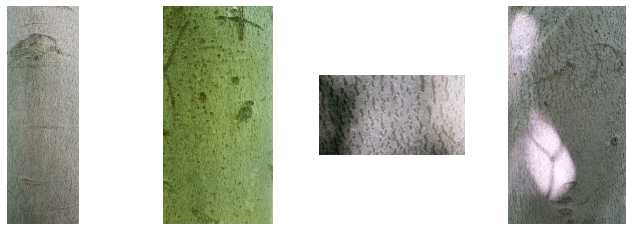

__________________________________________________________________________________________
MEL  Mélèze 
/content/lab_ecorces/train/MEL/854_MEL_124_GalaxyS5_20170706_113929_19.jpg
/content/lab_ecorces/train/MEL/868_MEL_100_GalaxyS5_20170706_120558_16.jpg
/content/lab_ecorces/train/MEL/867_MEL_136_GalaxyS5_20170706_120414_11.jpg
/content/lab_ecorces/train/MEL/806_MEL_85_GalaxyS5_20170622_093218_21.jpg


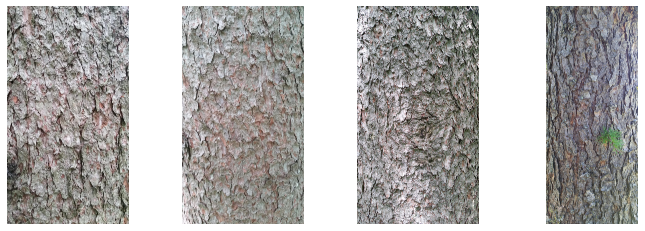

__________________________________________________________________________________________
ORA  Orme d'Amérique 
/content/lab_ecorces/train/ORA/630_ORA_63_GalaxyS5_20170607_142209_11.jpg
/content/lab_ecorces/train/ORA/626_ORA_64_GalaxyS7_20170607_134126_35.jpg
/content/lab_ecorces/train/ORA/627_ORA_151_GalaxyS7_20170607_134357_51.jpg
/content/lab_ecorces/train/ORA/630_ORA_63_GalaxyS7_20170607_142146_23.jpg


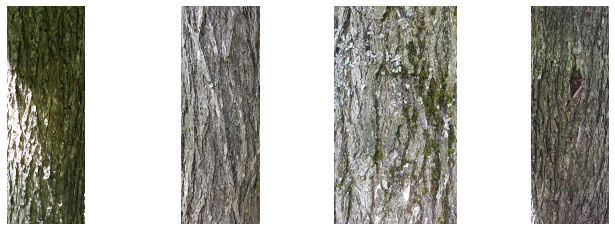

__________________________________________________________________________________________
OSV  Ostryer de Virginie 
/content/lab_ecorces/train/OSV/902_OSV_40_GalaxyS5_20170713_122813_10.jpg
/content/lab_ecorces/train/OSV/888_OSV_105_GalaxyS5_20170713_104958_37.jpg
/content/lab_ecorces/train/OSV/891_OSV_57_GalaxyS5_20170713_110203_16.jpg
/content/lab_ecorces/train/OSV/889_OSV_101_GalaxyS5_20170713_105344_16.jpg


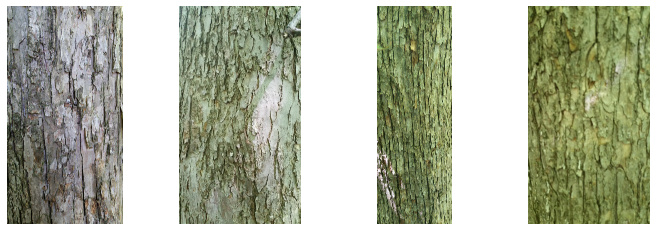

__________________________________________________________________________________________
PEG  Peuplier à grandes dents 
/content/lab_ecorces/train/PEG/905_PEG_46_GalaxyS5_20170713_112124_17.jpg
/content/lab_ecorces/train/PEG/904_PEG_43_GalaxyS5_20170713_111959_7.jpg
/content/lab_ecorces/train/PEG/905_PEG_46_GalaxyS5_20170713_112124_2.jpg
/content/lab_ecorces/train/PEG/906_PEG_55_GalaxyS5_20170713_112557_15.jpg


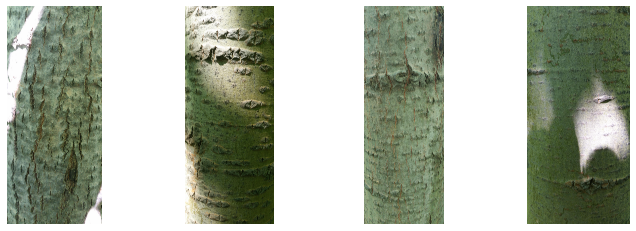

__________________________________________________________________________________________
PET  Peuplier faux tremble 
/content/lab_ecorces/train/PET/915_PET_98_GalaxyS5_20170712_103541_23.jpg
/content/lab_ecorces/train/PET/912_PET_274_GalaxyS5_20170712_102809_15.jpg
/content/lab_ecorces/train/PET/908_PET_78_GalaxyS5_20170712_101711_11.jpg
/content/lab_ecorces/train/PET/943_PET_68_GalaxyS5_20170712_112901_5.jpg


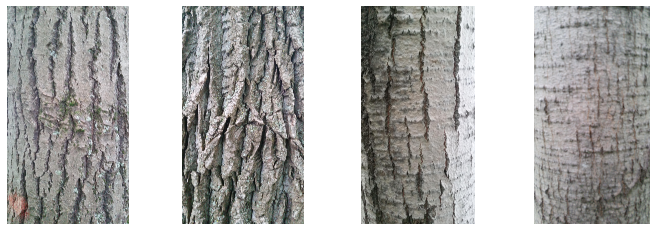

__________________________________________________________________________________________
PIB  Pin blanc 
/content/lab_ecorces/train/PIB/331_PIB_88_Nexus 5_20170615_125220_5.jpg
/content/lab_ecorces/train/PIB/322_PIB_120_Nexus 5_20170615_123821_17.jpg
/content/lab_ecorces/train/PIB/338_PIB_100_Nexus 5_20170615_132928_14.jpg
/content/lab_ecorces/train/PIB/966_PIB_87_GalaxyS5_20170615_130937_14.jpg


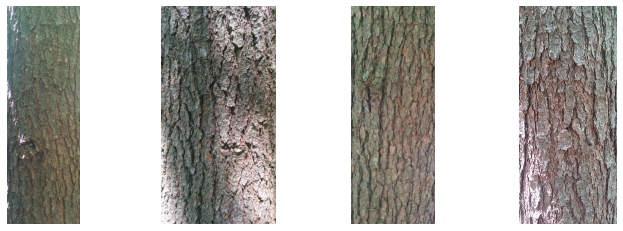

__________________________________________________________________________________________
PID  Pin rigide 
/content/lab_ecorces/train/PID/345_PID_165_Nexus 5_20170817_100536_2.jpg
/content/lab_ecorces/train/PID/345_PID_165_Nexus 5_20170817_103455_19.jpg
/content/lab_ecorces/train/PID/346_PID_77_Nexus 5_20170817_103045_24.jpg
/content/lab_ecorces/train/PID/348_PID_76_Nexus 5_20170817_103335_5.jpg


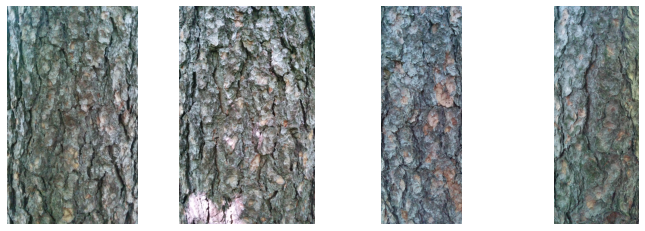

__________________________________________________________________________________________
PIR  Pin rouge 
/content/lab_ecorces/train/PIR/357_PIR_112_Nexus 5_20170817_110218_22.jpg
/content/lab_ecorces/train/PIR/631_PIR_72_GalaxyS7_20170607_142802_18.jpg
/content/lab_ecorces/train/PIR/358_PIR_88_Nexus 5_20170817_110336_8.jpg
/content/lab_ecorces/train/PIR/364_PIR_106_Nexus 5_20170817_112243_2.jpg


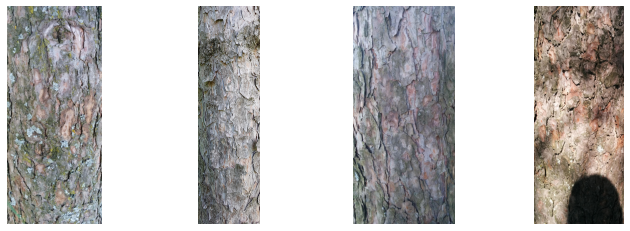

__________________________________________________________________________________________
PRU  Pruche du Canada 
/content/lab_ecorces/train/PRU/978_PRU_93_GalaxyS5_20170713_113317_8.jpg
/content/lab_ecorces/train/PRU/376_PRU_160_GalaxyS7_20170607_155417_2.jpg
/content/lab_ecorces/train/PRU/975_PRU_70_GalaxyS5_20170713_110707_4.jpg
/content/lab_ecorces/train/PRU/404_PRU_99_Nexus 5_20170906_092848_2.jpg


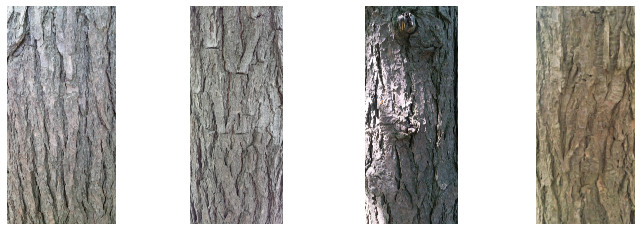

__________________________________________________________________________________________
SAB  Sapin Baumier 
/content/lab_ecorces/train/SAB/1003_SAB_73_GalaxyS5_20170622_113655_6.jpg
/content/lab_ecorces/train/SAB/985_SAB_77_GalaxyS5_20170615_134954_7.jpg
/content/lab_ecorces/train/SAB/417_SAB_61_Nexus 5_20170608_104003_19.jpg
/content/lab_ecorces/train/SAB/421_SAB_79_Nexus 5_20170615_125557_3.jpg


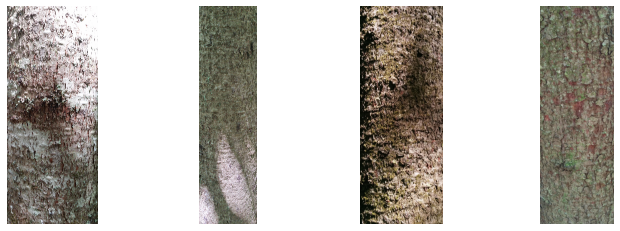

__________________________________________________________________________________________
THO  Thuya occidental 
/content/lab_ecorces/train/THO/435_THO_109_Nexus 5_20170810_101318_12.jpg
/content/lab_ecorces/train/THO/432_THO_54_Nexus 5_20170615_135113_6.jpg
/content/lab_ecorces/train/THO/428_THO_48_Nexus 5_20170615_122838_7.jpg
/content/lab_ecorces/train/THO/637_THO_93_GalaxyS5_20170607_141656_32.jpg


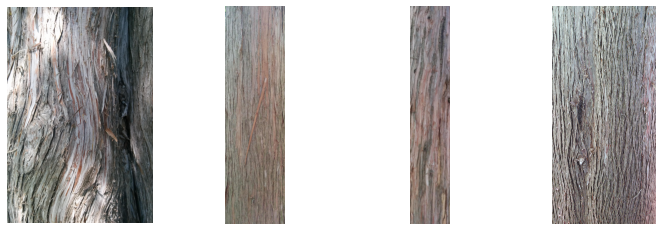

In [47]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 4

REPERTOIRE_ENTRAINEMENT = "/content/lab_ecorces/train/"

for arbre_id in dict_arbres.keys():
    try:
        dir_path = os.path.join(REPERTOIRE_ENTRAINEMENT,arbre_id+os.sep)
        liste_fichiers = os.listdir(os.path.join(REPERTOIRE_ENTRAINEMENT,arbre_id+os.sep))
        next_two_pics = [os.path.join(dir_path, fname) for fname in liste_fichiers[0:pic_index]]
        fig = plt.figure(figsize=(12,4))
        print("_"*90)
        print(arbre_id,dict_arbres[arbre_id].split('-')[1])
        for i, img_path in enumerate(next_two_pics):
            print(img_path)
            img = mpimg.imread(img_path)
            plt.subplot(1,pic_index,i+1)
            plt.imshow(img)
            plt.axis('Off')
        plt.show()
    except:
        continue


### Création de flux de lots de données pour l'entraînement

Chargeons ces images en mémoire en créant des `tf.data.dataset` à l'aide de l'utilitaire `tf.keras.utils.image_dataset_from_directory`. 

tf.data.Dataset prend en charge l'écriture de chaîne de traitement de données efficaces. L'itération se produit dans un flux continu, de sorte que l'ensemble complet de données  n'a pas besoin de tenir dans la mémoire.

In [48]:
import os
import numpy as np
import keras
print("Version de Keras:",keras.__version__)
import tensorflow as tf
print("Version de TensorFlow :",tf.__version__)

Version de Keras: 2.8.0
Version de TensorFlow : 2.8.0


In [49]:
REPERTOIRE_ENTRAINEMENT = "/content/lab_ecorces/train/"
REPERTOIRE_VALIDATION = "/content/lab_ecorces/val"
REPERTOIRE_TEST = "/content/lab_ecorces/test/"

TAILLE_LOT = 32
HAUTEUR_IMAGE = 150
LARGEUR_IMAGE = 150
TAILLE_IMAGE = (HAUTEUR_IMAGE, LARGEUR_IMAGE)
NOMBRE_CANAUX = 3

donnees_entrainement = tf.keras.utils.image_dataset_from_directory(REPERTOIRE_ENTRAINEMENT,
                                                                   batch_size=TAILLE_LOT,
                                                                   image_size=TAILLE_IMAGE)

Found 18813 files belonging to 23 classes.


In [50]:
print("Type Python de donnees_entrainement):",type(donnees_entrainement))
flux_images, flux_etiquettes = next(iter(donnees_entrainement))
print("Dimensions du flux d'images:",flux_images.shape)
print("Nombre d'images):",len(flux_images))
print("Dimensions du flux d'étiquettes:",flux_etiquettes.shape)
print("Nombre d'étiquettes):",len(flux_etiquettes))

Type Python de donnees_entrainement): <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Dimensions du flux d'images: (32, 150, 150, 3)
Nombre d'images): 32
Dimensions du flux d'étiquettes: (32,)
Nombre d'étiquettes): 32


In [51]:
liste_noms_classes = donnees_entrainement.class_names
print(liste_noms_classes)
nombre_de_classes = len(liste_noms_classes)
print('Nombre de classes:',nombre_de_classes)

['BOJ', 'BOP', 'CHR', 'EPB', 'EPN', 'EPO', 'EPR', 'ERB', 'ERR', 'ERS', 'FRA', 'HEG', 'MEL', 'ORA', 'OSV', 'PEG', 'PET', 'PIB', 'PID', 'PIR', 'PRU', 'SAB', 'THO']
Nombre de classes: 23


In [52]:
donnees_validation = tf.keras.utils.image_dataset_from_directory(REPERTOIRE_VALIDATION,
                                                                 batch_size=TAILLE_LOT,
                                                                 image_size=TAILLE_IMAGE)

Found 3518 files belonging to 23 classes.


In [53]:
donnees_test = tf.keras.utils.image_dataset_from_directory(REPERTOIRE_TEST,
                                                           batch_size=TAILLE_LOT,
                                                           image_size=TAILLE_IMAGE)

Found 1197 files belonging to 23 classes.


In [54]:
print("Nombre de lots de données d'entraînement: %d" % tf.data.experimental.cardinality(donnees_entrainement))
print("Nombre de lots de données de validation: %d" % tf.data.experimental.cardinality(donnees_validation))
print('Nombre de lots de données de test: %d' % tf.data.experimental.cardinality(donnees_test))


Nombre de lots de données d'entraînement: 588
Nombre de lots de données de validation: 110
Nombre de lots de données de test: 38


## Prétraitement des données

### Normalisation des données

In [55]:
couches_normalisation = keras.Sequential([
    keras.layers.Resizing(HAUTEUR_IMAGE,LARGEUR_IMAGE),
    keras.layers.Rescaling(1./255)
])

In [56]:
AUTOTUNE = tf.data.AUTOTUNE

def pretraitement(jeu_donnees, melanger=False, normaliser=False):

    if melanger:
        jeu_donnees = jeu_donnees.shuffle(1000)
            
    # Normaliser les jeux de données
    if normaliser:
        jeu_donnees = jeu_donnees.map(lambda x, y: (couches_normalisation(x), y),
                                    num_parallel_calls=AUTOTUNE
                                    )
    
    # Utiliser des tampons de préextraction sur tous les jeux de données
    return jeu_donnees.prefetch(buffer_size=AUTOTUNE)

print("Fonction de prétraitement prête!")

Fonction de prétraitement prête!


#### Normalisation des données d'entraînement

In [57]:
print("Type Python de donnees_entrainement):",type(donnees_entrainement))
donnees_entrainement_normalisees = pretraitement(donnees_entrainement,
                                                 melanger=True,
                                                 normaliser=True)
print("Type Python donnees_entrainement_normalisees):",type(donnees_entrainement_normalisees))
lot_images, lot_etiquettes = next(iter(donnees_entrainement_normalisees))
premiere_image = lot_images[0]
# Notez que les valeurs des pixels sont maintenant dans l'intervalle `[0,1]`
print(np.min(premiere_image), np.max(premiere_image))


Type Python de donnees_entrainement): <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Type Python donnees_entrainement_normalisees): <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
0.0 1.0


In [58]:
images, etiquettes = next(iter(donnees_entrainement_normalisees))
print("Dimensions flux d'images:",images.shape)
print("Nombre d'images:",len(images))
print("Dimensions flux d'étiquette:",etiquettes.shape)
print("Nombre d'étiquettes:",len(images))


Dimensions flux d'images: (32, 150, 150, 3)
Nombre d'images: 32
Dimensions flux d'étiquette: (32,)
Nombre d'étiquettes: 32


#### Normalisation des données de validation

In [59]:
print("Type Python de donnees_validation):",type(donnees_validation))
donnees_validation_normalisees = pretraitement(donnees_validation,
                                               melanger=False,
                                               normaliser=True)
print("Type Python donnees_validation_normalisees):",type(donnees_validation_normalisees))
lot_images, lot_etiquettes = next(iter(donnees_validation_normalisees))
premiere_image = lot_images[0]
# Notez que les valeurs des pixels sont maintenant dans l'intervalle `[0,1]`
print(np.min(premiere_image), np.max(premiere_image))


Type Python de donnees_validation): <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Type Python donnees_validation_normalisees): <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
0.093256384 1.0


In [60]:
images, etiquettes = next(iter(donnees_validation_normalisees))
print("Dimensions flux d'images:",images.shape)
print("Nombre d'images:",len(images))
print("Dimensions flux d'étiquette:",etiquettes.shape)
print("Nombre d'étiquettes:",len(images))


Dimensions flux d'images: (32, 150, 150, 3)
Nombre d'images: 32
Dimensions flux d'étiquette: (32,)
Nombre d'étiquettes: 32


#### Normalisation des données de test

In [61]:
print("Type Python de donnees_test):",type(donnees_test))
AUTOTUNE = tf.data.AUTOTUNE
donnees_test = donnees_test.cache().prefetch(buffer_size=AUTOTUNE)
print("Type Python de donnees_test):",type(donnees_test))
donnees_test_normalisees = donnees_test.map(lambda x, y: (couches_normalisation(x), y))
print("Type Python de donnees_test_normalisees:",type(donnees_test_normalisees))
lot_images, lot_etiquettes = next(iter(donnees_test_normalisees))
premiere_image = lot_images[0]
# Notez que les valeurs des pixels sont maintenant dans l'intervalle `[0,1]`
print(np.min(premiere_image), np.max(premiere_image))


Type Python de donnees_test): <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Type Python de donnees_test): <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Type Python de donnees_test_normalisees: <class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
0.0 1.0


In [62]:
images, etiquettes = next(iter(donnees_test_normalisees))
print("Dimensions flux d'images:",images.shape)
print("Nombre d'images:",len(images))
print("Dimensions flux d'étiquette:",etiquettes.shape)
print("Nombre d'étiquettes:",len(images))


Dimensions flux d'images: (32, 150, 150, 3)
Nombre d'images: 32
Dimensions flux d'étiquette: (32,)
Nombre d'étiquettes: 32


## Création d'un modèle d'apprentissage par transfert

### Importation d'un modèle `inception` pré-entraîné sur `ImageNet`

In [63]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
    

--2022-03-15 05:25:43--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.13.240, 172.253.63.128, 172.217.164.176, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.13.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   232MB/s    in 0.4s    

2022-03-15 05:25:43 (232 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [64]:
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.applications.inception_v3 import InceptionV3

# Charger les paramètres ou poids du modèle InceptionV3 pré-entraîné sur ImageNet
modele_preentraine = InceptionV3(weights='imagenet',
                                 input_shape = (HAUTEUR_IMAGE,LARGEUR_IMAGE,NOMBRE_CANAUX),
                                 include_top = False)


87924736/87910968 [==============================] - 1s 0us/step


In [65]:
print("Architecture du modèle préentraîné")
modele_preentraine.summary()

Architecture du modèle préentraîné
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                    

### Module d'extraction d'attributs visuels

#### Détermination de la couche de sortie et de la couche où débute le peaufinage

In [66]:
modele_preentraine.trainable = True

# Combien de couches se trouvent dans le modèle pré-entraîné
nbr_couches_modele_preentraine = len(modele_preentraine.layers)
print("Nombre de couches dans le modèle pré-entraîné d'origine: ", nbr_couches_modele_preentraine)

# Comment obtenir l'index de la couche à partir de l'identifiant de la couche 
# https://www.thetopsites.net/article/50151157.shtml
liste_noms_de_couche = [couche.name for couche in modele_preentraine.layers]
nom_derniere_couche = liste_noms_de_couche[-1]
print("Nom de la dernière couche du modèle pré-entraîné complet:",nom_derniere_couche)
index_derniere_couche = liste_noms_de_couche.index(nom_derniere_couche)
print("Index de la dernière couche du modèle pré-entraîné complet:",index_derniere_couche)

# Choix d'une nouvelle couche de sortie par essai / erreur
# cette étape assez laborieuse a été réalisée pour vous simplifier la tâche
nom_derniere_couche = 'mixed5'
print("Choix empirique de la dernière couche du modèle pré-entraîné:",nom_derniere_couche)
index_derniere_couche = liste_noms_de_couche.index(nom_derniere_couche)
print("Index de la dernière couche du modèle pré-entraîné choisie empiriquement:",index_derniere_couche)

# Choix de la dernière couche non-entraînable ou dernière couche « gelée » du modèle pré-entraîné
nom_derniere_couche_gelee = 'mixed3'
print("Choix empirique de la dernière couche non-entraînable:",nom_derniere_couche_gelee)
index_derniere_couche_gelee = liste_noms_de_couche.index(nom_derniere_couche_gelee)
print("Index de la dernière couche non-entraînable:",index_derniere_couche_gelee)
# Paufiner l'entraînement à partir de la dernière couche non-entraînable
debut_paufinage = index_derniere_couche_gelee
print("Nombre de couches gelées (non entraînables) dans le modèle préentraîné: ", debut_paufinage )
# Geler tous les couches avant la couche `debut_paufinage`
for couche in modele_preentraine.layers[:debut_paufinage]:
    couche.trainable =  False

print("Nombre de couches entraînables dans le modèle préentraîné: ", index_derniere_couche-debut_paufinage)
derniere_couche = modele_preentraine.get_layer(nom_derniere_couche)
print('Dimensions de la dernière couche: ', derniere_couche.output_shape)
sortie_derniere_couche = derniere_couche.output


Nombre de couches dans le modèle pré-entraîné d'origine:  311
Nom de la dernière couche du modèle pré-entraîné complet: mixed10
Index de la dernière couche du modèle pré-entraîné complet: 310
Choix empirique de la dernière couche du modèle pré-entraîné: mixed5
Index de la dernière couche du modèle pré-entraîné choisie empiriquement: 164
Choix empirique de la dernière couche non-entraînable: mixed3
Index de la dernière couche non-entraînable: 100
Nombre de couches gelées (non entraînables) dans le modèle préentraîné:  100
Nombre de couches entraînables dans le modèle préentraîné:  64
Dimensions de la dernière couche:  (None, 7, 7, 768)


### Ajout d'un module de *classification*

#### Perceptron multicouche

In [67]:
# Ajouter une couche de régularisation par extinction de neurones (dropout)
sorties = layers.Dropout(0.1)(sortie_derniere_couche)
# Aplatir la couche de sortie en un vecteur (i.e. une dimension)
sorties = layers.Flatten()(sorties)
# Ajouter une couche entièrement connectée avec 1024 neurones cachés et l'activation ReLU
sorties = layers.Dense(1024, activation='relu')(sorties)
# Ajouter une couche de régularisation par extinction (dropout)
sorties = layers.Dropout(0.2)(sorties)      
# Ajouter une couche de sortie entièrement connectée de 20 neurones 
# avec l'activation softmax (exponentielle normalisée)
# *** IMPORTANT *** 20 classes => 20 neurones de sortie
sorties = layers.Dense(nombre_de_classes, activation='softmax')(sorties)           
modele_de_transfert = Model(modele_preentraine.input, sorties) 
print("Nombre de couches dans le modèle d'apprentissage par transfert: ", len(modele_de_transfert.layers))


Nombre de couches dans le modèle d'apprentissage par transfert:  170


In [68]:
print("Architecture complète")
modele_de_transfert.summary()

Architecture complète
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                        

In [69]:
print("Nombre de paramètres entraînables dans le modèle de transfert: ",len(modele_de_transfert.trainable_variables))


Nombre de paramètres entraînables dans le modèle de transfert:  44


## Compilation du modèle

In [70]:
from tensorflow.keras.optimizers import RMSprop

# D'après la documentation, tf.keras.utils.image_dataset_from_directory, encodera par défaut 
# un ensemble d'étiquettes de classes sous forme d'entiers allant de 1 au nombre de classes.
# Dans ce cas, le modèle doit être compilé avec une fonction d'erreur 'sparse_categorical_crossentropy'

modele_de_transfert.compile(optimizer = RMSprop(learning_rate=0.0001),
                            loss = 'sparse_categorical_crossentropy',
                            metrics = ['accuracy'])

print("Modèle compilé!")


Modèle compilé!


## Entraînement du modèle

In [ ]:
nombre_iterations_de_base = 10
nombre_iterations_peaufinage = 30
nombre_total_iterations =  nombre_iterations_de_base + nombre_iterations_peaufinage

# Les fonctions de rappels sont passées au modèle via l'argument callbacks de .fit(...), 
# qui prend une liste de fonctions de rappels. 
liste_fonctions_rappels = [
    # Mémoriser le meilleur modèle
    keras.callbacks.ModelCheckpoint(
        filepath="IdEcorces_ResConv_TransAmpl.keras",
        save_best_only=True,
        # Surveiller l'erreur de validation
        monitor="val_loss"),
    # Arrêter l'entraînement quand son amélioration stagne
    keras.callbacks.EarlyStopping(
        # Surveiller l'exactitude de validation
        monitor='val_accuracy',
        # Arrêter l'entraînement quand l'exactitude stagne
        # depuis plus de 10 itérations (i.e., 11 itérations)
        patience=10,
        verbose=2),
    # Ajuster le taux taux d'apprentissage ou gain du gradient
    keras.callbacks.ReduceLROnPlateau(
        # Surveiller l'erreur de validation
        monitor='val_loss',
        # Diviser le taux d'apprentissage par 2 
        # lorsque la fonction de rappel est déclenchée
        factor=0.5,
        # La fonction de rappel est déclenchée quand l'erreur de validation 
        # a cessé de s'améliorer depuis 3 itérations
        patience=3,
        verbose=2) 
]

traces_entrainement = modele_de_transfert.fit(donnees_entrainement_normalisees,
                                              validation_data = donnees_validation_normalisees,
                                              epochs = nombre_total_iterations,
                                              callbacks=liste_fonctions_rappels,
                                              verbose = 2)


Epoch 1/40


### Affichage des courbes d'entraînement

In [ ]:
# Dernière couche 'mixed5', dernière couche gelée 'mixed3'
# 40 itérations & amplification
# exactitude sur les données de test: de 80 à 85%
import matplotlib.pyplot as plt
exactitude_entrainement = traces_entrainement.history['accuracy']
exactitude_validation = traces_entrainement.history['val_accuracy']
erreur_entrainement = traces_entrainement.history['loss']
erreur_validation = traces_entrainement.history['val_loss']
nombre_iterations = range(len(exactitude_entrainement))
nombre_dor = 1.618
hauteur = 6
longueur = int(nombre_dor * hauteur)
plt.figure(figsize=(longueur,hauteur))
plt.plot(nombre_iterations, exactitude_entrainement, 'r', label='Exactitude entraînement')
plt.plot(nombre_iterations, exactitude_validation, 'b', label='Exactitude validation')
plt.title("Exactitude en entraînement & validation - apprentissage par transfert & amplification des données")
plt.legend(loc=0)
plt.xlabel("Nombre d'itérations")
plt.ylabel("Exactitude")
plt.show()


### Évaluation du modèle avec les données de test

In [ ]:
erreur_test, exactitude_test = modele_de_transfert.evaluate(donnees_test_normalisees)
print("Exactitude sur les données de test: %0.2f" % exactitude_test)


### Résultats

Les résultats obtenus se situent dans une fourchette de 75 à 80% pour le jeu de données mini-BarkNet, ce qui est un bon départ considérant l'emploi de 1.5 Go de données (21 fois moins de données) que le jeu de données BarkNet original de 32 Go où l,on obtient un résultat entre XXXXX et YYYYYY 

### Analyse des résultats sur les données de test

#### Prédictions sur les données de test

Extraction des étiquettes prédites

In [ ]:
predictions = modele_de_transfert.predict(donnees_test_normalisees)
index_predictions = np.argmax(predictions, axis=1)
liste_etiquettes_predites = [(etiquette+1) for etiquette in index_predictions]
print(liste_etiquettes_predites)


Extraction des vraies étiquettes

In [ ]:
index_vraies_etiquettes = list(np.concatenate([etiquette for image, etiquette in donnees_test_normalisees], axis=0))
liste_vraies_etiquettes = [(etiquette+1) for etiquette in index_vraies_etiquettes]
print(liste_vraies_etiquettes)


Calcul de l'exactitude sur les données de test

In [ ]:
from sklearn import metrics

exactitude_test = metrics.accuracy_score(liste_vraies_etiquettes, liste_etiquettes_predites)
print("Exactitude:   %0.2f" % exactitude_test)


#### Affichage d'une matrice de confusion

In [ ]:
# https://stackoverflow.com/questions/65618137/confusion-matrix-for-multiple-classes-in-python

import itertools

def afficher_matrice_de_confusion(matrice_confusion_brute, classes,
                          normalisation=False,
                          titre='Matrice de confusion',
                          carte_des_couleurs=plt.cm.Blues):
    plt.figure(figsize=(14,12))
    plt.imshow(matrice_confusion_brute, interpolation='nearest', cmap=carte_des_couleurs)
    plt.title(titre)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalisation:
        matrice_confusion_brute = matrice_confusion_brute.astype('float') / matrice_confusion_brute.sum(axis=1)[:, np.newaxis]
        print("Matrice de confusion normalisée")
    else:
        print('Matrice de confusion non normalisée')

    seuil = matrice_confusion_brute.max() / 2.
    for i, j in itertools.product(range(matrice_confusion_brute.shape[0]), range(matrice_confusion_brute.shape[1])):
        plt.text(j, i, matrice_confusion_brute[i, j],
                 horizontalalignment="center",
                 color="white" if matrice_confusion_brute[i, j] > seuil else "black")

    plt.tight_layout()
    plt.ylabel('Vraies étiquettes')
    plt.xlabel('Étiquettes prédites')

    
print("Code affichage matrice de confusion")


In [ ]:
matrice_confusion_brute = metrics.confusion_matrix(liste_vraies_etiquettes, liste_etiquettes_predites)
afficher_matrice_de_confusion(matrice_confusion_brute, classes=liste_noms_classes)


#### Rapport de classification

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(liste_vraies_etiquettes, liste_etiquettes_predites, target_names=liste_noms_classes))


In [ ]:
print("Fin de l'exécution du carnet IPython")